In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

2022-05-24 14:58:22.376854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 14:58:22.376890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [4]:
for expression in os.listdir("./facial-expression/train"):
    print(str(len(os.listdir("./facial-expression/train/" + expression))) + " " + expression + " images")

7215 happy images
3171 surprise images
4965 neutral images
4097 fear images
436 disgust images
3995 angry images
4830 sad images


In [5]:
img_size = 48
batch_size = 64

In [6]:
datagen_train = ImageDataGenerator(horizontal_flip=True)

In [7]:
train_generator = datagen_train.flow_from_directory("./facial-expression/train/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=True)

Found 28709 images belonging to 7 classes.


In [8]:
datagen_validation = ImageDataGenerator(horizontal_flip=True)

In [9]:
validation_generator = datagen_validation.flow_from_directory("./facial-expression/test/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=False)

Found 7178 images belonging to 7 classes.


In [10]:
model = Sequential()

2022-05-24 14:58:25.103197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 14:58:25.103216: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 14:58:25.103228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (M9): /proc/driver/nvidia/version does not exist
2022-05-24 14:58:25.103849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# 1 - Convolution
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [13]:
# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [14]:
# 4th Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [15]:
model.add(Flatten())

In [16]:
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

In [17]:
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

In [18]:
model.add(Dense(7, activation='softmax'))

In [19]:
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

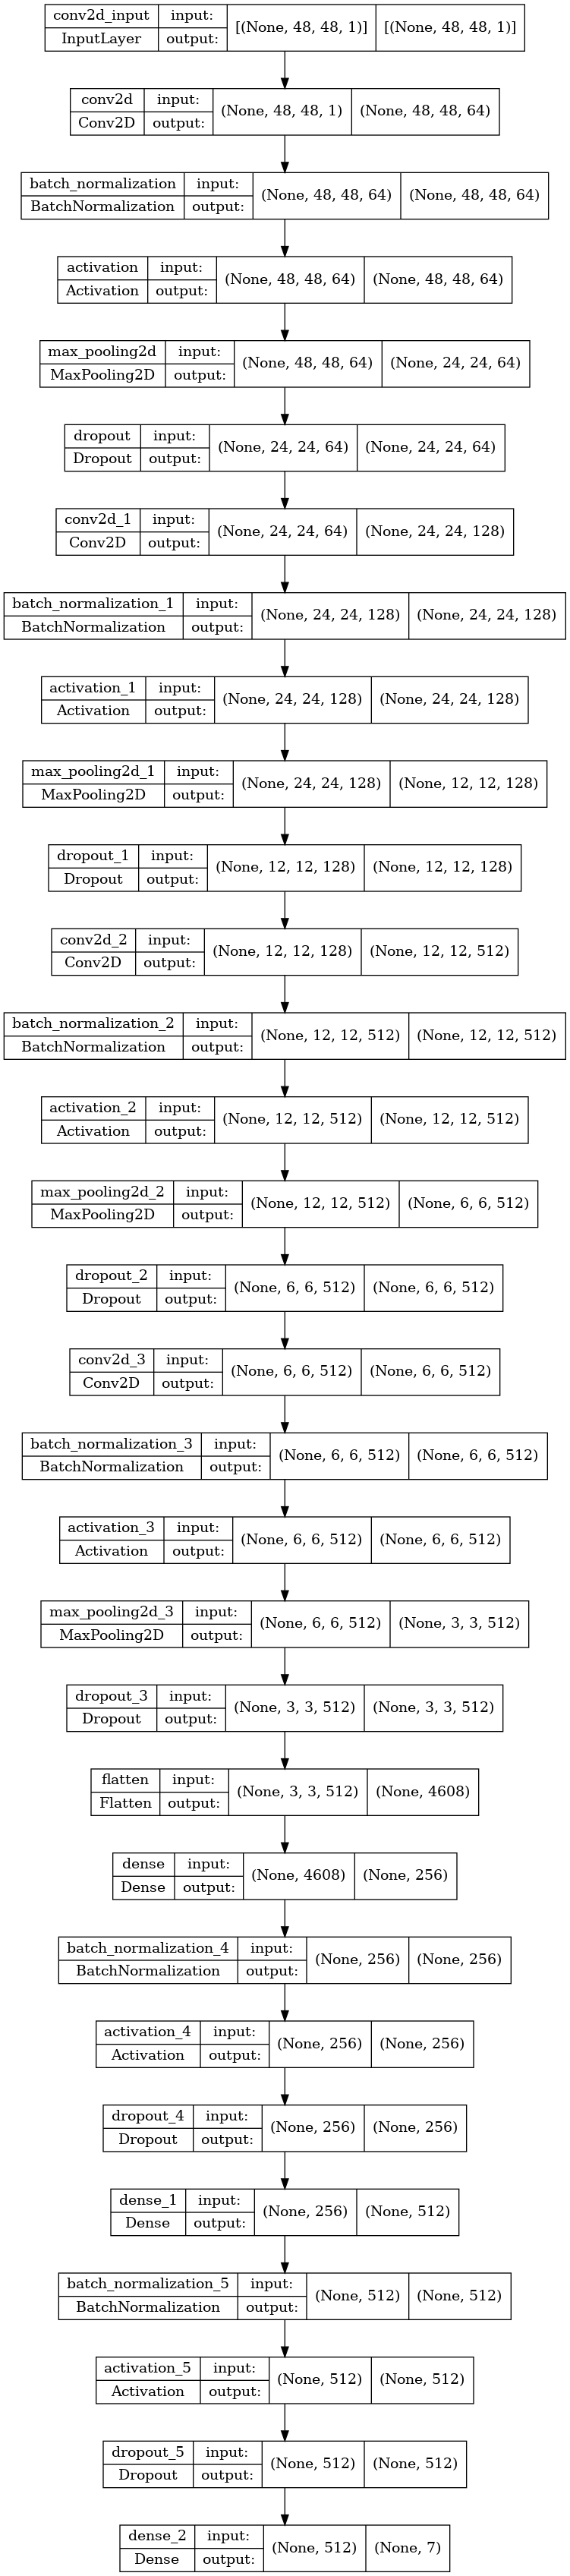

In [20]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

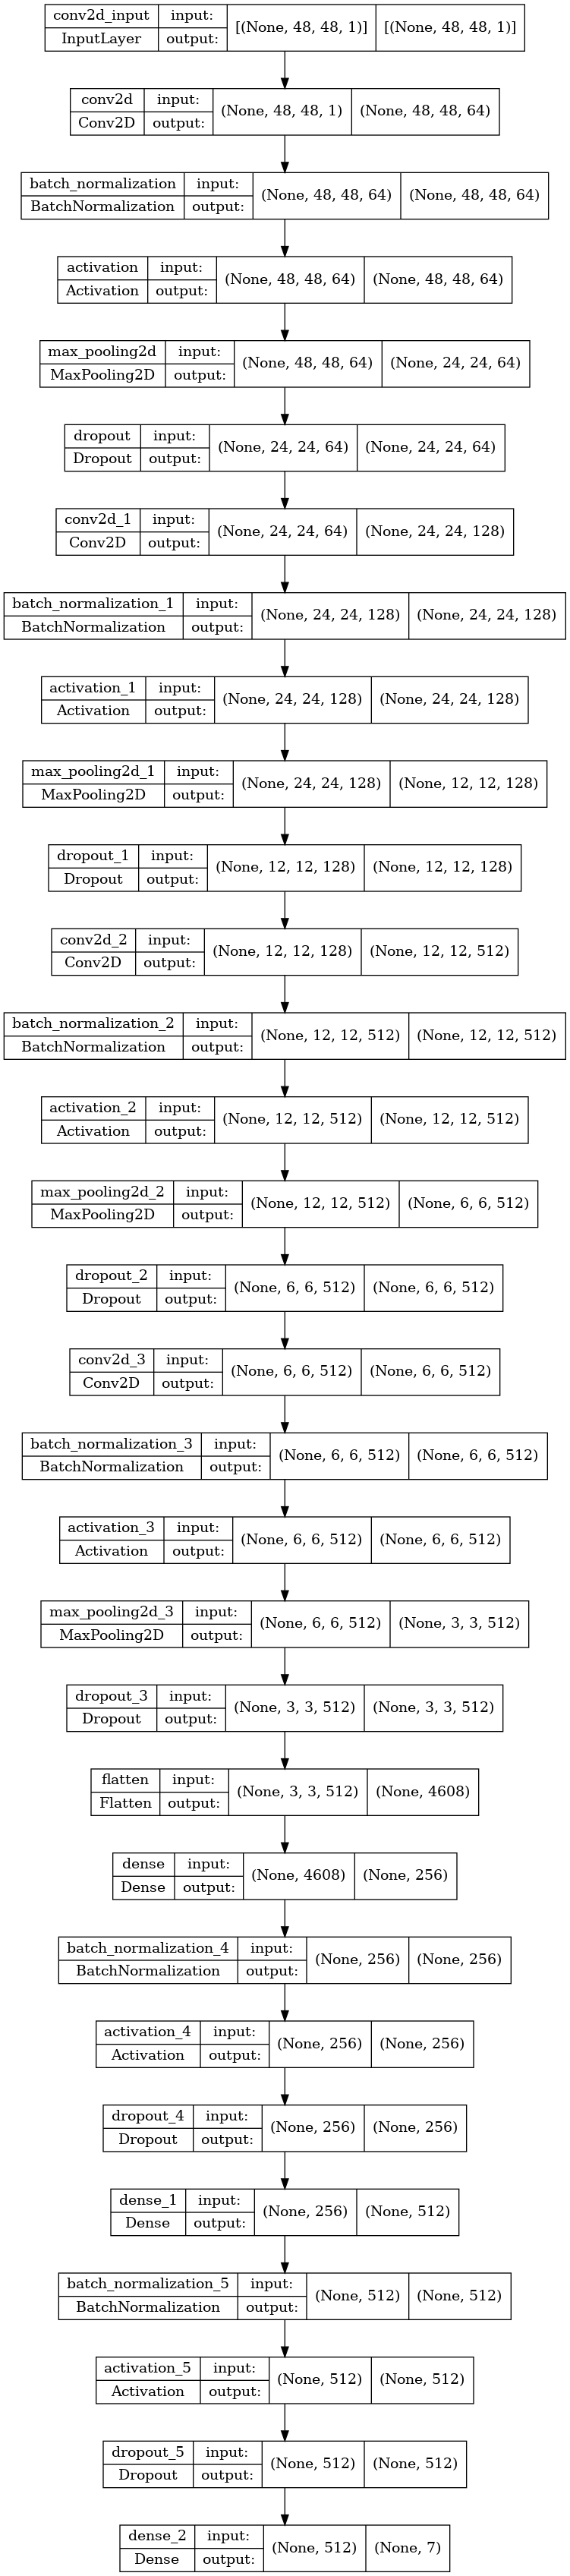

In [21]:
Image('model.png', width=400, height=200)

In [ ]:
%%time

epochs = 80
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x=train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=validation_steps, 
    callbacks=callbacks
)

Epoch 1/80


2022-05-24 14:58:42.566109: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-05-24 14:58:42.626438: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-05-24 14:58:42.673901: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-05-24 14:58:42.730264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-05-24 14:58:42.746398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.


448/448 [==============================] - ETA: 0s - loss: 1.7777 - accuracy: 0.3182
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 426s 949ms/step - loss: 1.7777 - accuracy: 0.3182 - val_loss: 1.5841 - val_accuracy: 0.4160 - lr: 5.0000e-04
Epoch 2/80
448/448 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.4421
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 421s 940ms/step - loss: 1.4594 - accuracy: 0.4421 - val_loss: 1.3648 - val_accuracy: 0.4841 - lr: 5.0000e-04
Epoch 3/80
448/448 [==============================] - ETA: 0s - loss: 1.3116 - accuracy: 0.4960
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 422s 943ms/step - loss: 1.3116 - accuracy: 0.4960 - val_loss: 1.2226 - val_accuracy: 0.5345 - lr: 5.0000e-04
Epoch 4/80
448/448 [==============================] - ETA: 0s - loss: 1.2364 - accuracy: 0.5308
Epoch 4: saving model to model_weights.h5
448

448/448 [==============================] - ETA: 0s - loss: 0.8727 - accuracy: 0.6715
Epoch 29: saving model to model_weights.h5
448/448 [==============================] - 435s 970ms/step - loss: 0.8727 - accuracy: 0.6715 - val_loss: 0.9603 - val_accuracy: 0.6497 - lr: 1.0000e-05
Epoch 30/80
448/448 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6724
Epoch 30: saving model to model_weights.h5
448/448 [==============================] - 431s 963ms/step - loss: 0.8717 - accuracy: 0.6724 - val_loss: 0.9590 - val_accuracy: 0.6489 - lr: 1.0000e-05
Epoch 31/80
448/448 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.6713
Epoch 31: saving model to model_weights.h5
448/448 [==============================] - 430s 960ms/step - loss: 0.8716 - accuracy: 0.6713 - val_loss: 0.9581 - val_accuracy: 0.6465 - lr: 1.0000e-05
Epoch 32/80
448/448 [==============================] - ETA: 0s - loss: 0.8659 - accuracy: 0.6759
Epoch 32: saving model to model_weights

448/448 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6895
Epoch 57: saving model to model_weights.h5
448/448 [==============================] - 502s 1s/step - loss: 0.8318 - accuracy: 0.6895 - val_loss: 0.9496 - val_accuracy: 0.6557 - lr: 1.0000e-05
Epoch 58/80
448/448 [==============================] - ETA: 0s - loss: 0.8340 - accuracy: 0.6860
Epoch 58: saving model to model_weights.h5
448/448 [==============================] - 501s 1s/step - loss: 0.8340 - accuracy: 0.6860 - val_loss: 0.9566 - val_accuracy: 0.6511 - lr: 1.0000e-05
Epoch 59/80
448/448 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.6896
Epoch 59: saving model to model_weights.h5
448/448 [==============================] - 502s 1s/step - loss: 0.8264 - accuracy: 0.6896 - val_loss: 0.9480 - val_accuracy: 0.6567 - lr: 1.0000e-05
Epoch 60/80
448/448 [==============================] - ETA: 0s - loss: 0.8278 - accuracy: 0.6896
Epoch 60: saving model to model_weights.h5
448/4

AttributeError: 'DirectoryIterator' object has no attribute 'batch'